## PlotBot Project

##### Objectives:
Build a Twitter bot that sends out visualized sentiment analysis of a Twitter account's recent tweets.

The bot receives tweets via mentions and in turn performs sentiment analysis on the most recent twitter account specified in the mention:

For example, when a user tweets, __"@PlotBot Analyze: @CNN,"__ it will trigger a sentiment analysis on the CNN twitter feed. 

##### Requirements:

* Bot should scan your account every __five minutes__ for mentions.
* Bot should pull 500 most recent tweets to analyze for each incoming request.
* Script should prevent abuse by analyzing __only__ Twitter accounts that have not previously been analyzed.
* Plot should include meaningful legend and labels and also mention the Twitter account name of the requesting user.
* Notable libraries used to complete this application include: Matplotlib, Pandas, Tweepy, TextBlob, and Seaborn.

In [53]:
# Dependencies
import tweepy
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import time
#from textblob import TextBlob
#import nltk

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys saved into environment variables
consumer_key = os.environ['twitter_consumer_key']
consumer_secret = os.environ['twitter_consumer_secret']
access_token = os.environ['twitter_access_token']
access_token_secret = os.environ['twitter_access_secret']

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [3]:
# This function passes text to the vader sentiment analyzer and returns the 'compound' value
def vaderpolarity(text):
    results = analyzer.polarity_scores(text)
    compound = results['compound']
    return(compound)
    # print(compound)

# Testing the function
#output = vaderpolarity("happy birthday")
#output

In [71]:
# This function pulls tweets from the 'target_feed' and saves the sentiment 'compound' values and 'tweets ago' to a dictionary
def getsentiments(target_feed):
    sentiments = []
    oldest_tweet = None
    counter = 1
    #loop through 5 times to retrieve a total of 5 x 100 = 500 tweets
    for x in range(5):
        feed_tweets = api.user_timeline(target_feed, 
                                          count=100,
                                          result_type="recent",
                                          max_id=oldest_tweet)
        for tweet in feed_tweets:
            compound = vaderpolarity(tweet["text"])
            tweets_ago = counter
            sentiments.append({"Polarity": compound,
                               "Tweets Ago": tweets_ago
                              })
            counter +=1
        oldest_tweet = int(tweet['id_str'])-1
    sentiments_pd = pd.DataFrame.from_dict(sentiments)
    return(sentiments_pd)

# Testing the function
#target_feed = "CNN"
#now = dt.datetime.now()
#now = now.strftime("%Y-%m-%d")
#sentiments_pd = getsentiments(target_feed)
#sentiments_pd.head(1)

In [8]:
def plotandsave(polarity,tweets_ago):
    sns.set()
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(sentiments_pd['Polarity'])),
                       sentiments_pd['Polarity'], marker='o', linewidth=1,
                       color='blue', alpha=0.5)
    plt.title(f"Sentiment Analysis of @{target_feed} Tweets ({now}) requested by {tweet_author}")
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    plt.xlim(-10,510)
    plt.legend(loc='best',)
    plt.savefig(f"{target_feed}.png")
    plt.show()

# Testing the function
#tweet_author = "testing"
#target_feed = "CNN"
#now = dt.datetime.now()
#now = now.strftime("%Y-%m-%d")
#sentiments = getsentiments(target_feed)
#sentiments_pd = pd.DataFrame.from_dict(sentiments)
#plotandsave(sentiments_pd['Polarity'],sentiments_pd['Tweets Ago'])

@tli2001a Analyze: @BarackObama


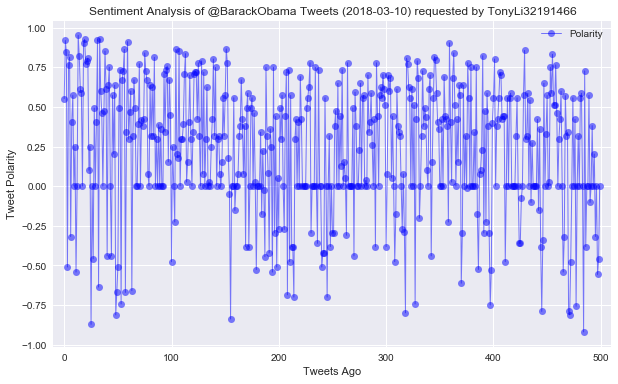

@tli2001a Analyze: @CNN


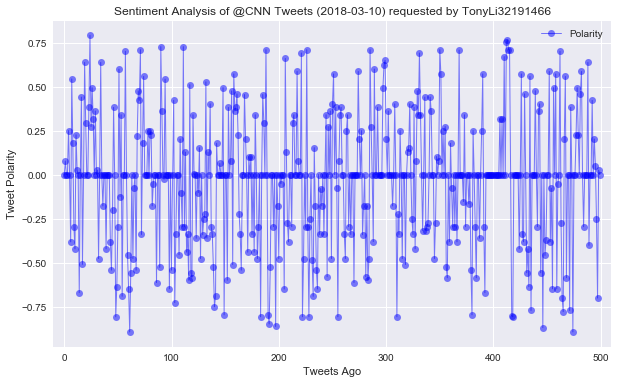

@tli2001a Analyze: @Oprah


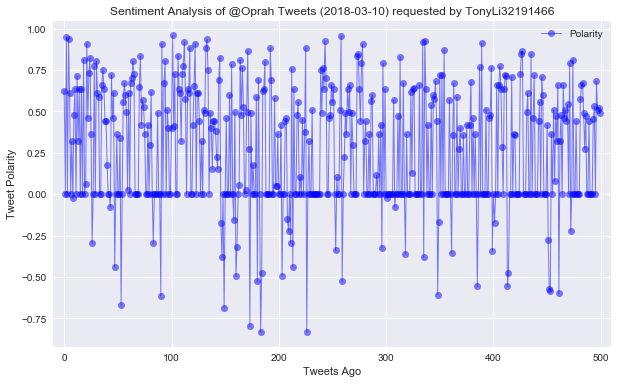

@tli2001a Analyze: @BBC


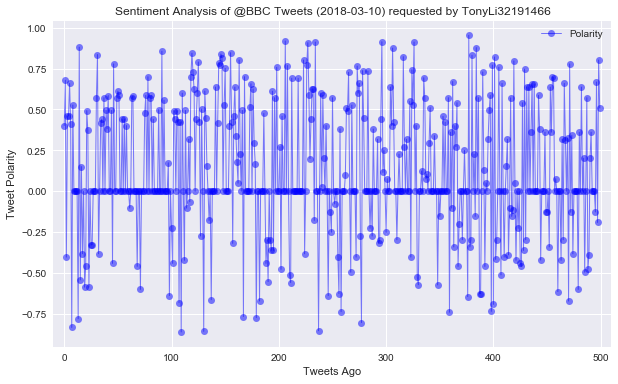

@tli2001a Analyze: @Oprah
already analyzed: Oprah
At end of loop 1

Last tweet is: @tli2001a Analyze: @Oprah, tweet 972377723472523264

sleeping for 10 seconds...

@tli2001a Analyze: @BarackObama
already analyzed: Oprah
At end of loop 2

Last tweet is: @tli2001a Analyze: @BarackObama, tweet 972377723472523264

sleeping for 10 seconds...



In [98]:
# bot activation trigger
botname = "@tli2001a"
trigger = (f"{botname} Analyze:")

# set up empty analyzed feeds list
analyzed_feeds_l = []

last_id = None
loop_counter = 1
tweet_counter = 0

interval = 60 # 60 seconds or 1 minute intervals
t_end = time.time() + interval * 5 # loop this for 5 minutes
while(time.time() < t_end):
    # Search for all tweets
    public_tweets = api.search(botname, 
                               count=20, 
                               result_type="recent", 
                               since_id=last_id)
     # Check for any new tweets
    if public_tweets["statuses"]:
#        print(len(public_tweets["statuses"]))
        # Loop through all new tweets
        for tweet in public_tweets["statuses"]:
            tweet_text = tweet['text']
            print(tweet_text)
            # Verify Trigger or skip tweet
            if trigger not in tweet_text:
                print(f"No Trigger: {tweet_text}")
                break
            else:
                # Get mentions and target feed
                user_mentions = public_tweets['statuses'][tweet_counter]['entities']['user_mentions']
                target_feed = user_mentions[1]['screen_name']
                # Check whether feed was already analyzed
                if target_feed in analyzed_feeds_l:
                    print(f"already analyzed: {target_feed}")
                    break
                else:
                    analyzed_feeds_l.append(target_feed)
                    # Get id and author of tweet
                    tweet_id = tweet["id"]
                    tweet_author = tweet["user"]["screen_name"]
            sentiments_pd = getsentiments(target_feed)
            # preserving time analysis was run
            now = dt.datetime.now()
            now = now.strftime("%Y-%m-%d")
            plotandsave(sentiments_pd['Polarity'],sentiments_pd['Tweets Ago'])
            # Respond to tweet
            api.update_with_media(f"{target_feed}.png",
                                  f"Tweet Analysis: {target_feed} (Thx {tweet_author}!)",
                                  in_reply_to_status_id=tweet_id)
            tweet_counter += 1
            continue
    print(f"At end of loop {loop_counter}\n")
    print(f"Last tweet is: {tweet_text}, tweet {tweet_id}\n")
    print(f"sleeping for {interval} seconds...\n")
    loop_counter += 1
#    last_id = tweet_id
    time.sleep(interval)

In [99]:
analyzed_feeds_l

['BarackObama', 'CNN', 'Oprah', 'BBC']